In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas_datareader as pdr
from forex_python.converter import CurrencyRates
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# You'll have to install these. If pip install doesn't work, try pip3 install.
pip install pandas_datareader
pip install forex_python
pip install statsmodels
pip3 install sklearn
pip3 install scikit-learn

In [3]:
treasury = yf.download("^TNX", start = "2013-08-19", end = "2023-08-17" )
silver = pd.read_csv('/Users/aidanolson/Desktop/gold and silver project/silver prices.csv')
gold = pd.read_csv('/Users/aidanolson/Desktop/gold and silver project/gold prices.csv')
treasury = treasury.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [4]:
silver.info() #Need to fix NA values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2539 non-null   object 
 1   Close/Last  2539 non-null   float64
 2   Volume      2476 non-null   float64
 3   Open        2539 non-null   float64
 4   High        2539 non-null   float64
 5   Low         2539 non-null   float64
dtypes: float64(5), object(1)
memory usage: 119.1+ KB


In [5]:
silver_null = silver.isnull().sum()
print(silver_null)

Date           0
Close/Last     0
Volume        63
Open           0
High           0
Low            0
dtype: int64


There are 63 null volumes, so we can replace these with the average of the non null volumes to ensure that these values don't mess with the aggregations of our data.

In [6]:
silver['Date'] = pd.to_datetime(silver['Date'])
silver['Year'] = silver['Date'].dt.year
gold['Date'] = pd.to_datetime(gold['Date'])
gold['Year'] = gold['Date'].dt.year
treasury['Date'] = pd.to_datetime(treasury['Date'])
treasury['Year'] = treasury['Date'].dt.year

In [7]:
silver_volume_mean = silver.groupby('Year')['Volume'].mean()
silver_volume_mean

Year
2013    34946.614458
2014    40468.616935
2015    39194.807692
2016    54560.357143
2017    70795.003984
2018    70378.805556
2019    60724.437247
2020    70472.349398
2021    60169.353175
2022    50334.490040
2023    57467.439490
Name: Volume, dtype: float64

In [8]:
for year, mean_value in silver_volume_mean.items():
    silver.loc[(silver['Year'] == year) & (silver['Volume'].isna()), 'Volume'] = mean_value

silver.isna().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
Year          0
dtype: int64

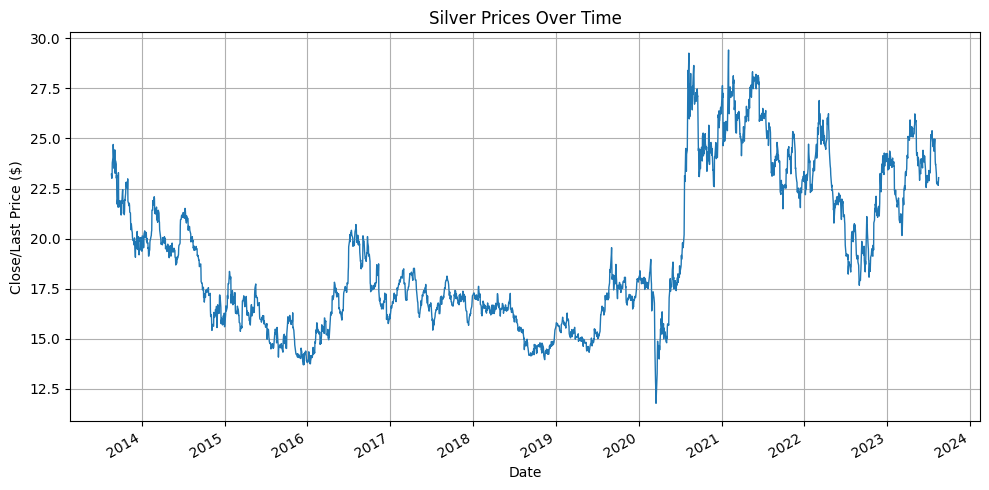

In [9]:
#Start plotting
plt.figure(figsize=(10, 5))

#Create line plot
plt.plot(silver['Date'], silver['Close/Last'], linewidth=1)  

#Adding the title and labels
plt.title('Silver Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last Price ($)')

plt.gcf().autofmt_xdate()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
silver['Daily Return'] = silver['Close/Last'].pct_change().dropna()
gold['Daily Return'] = gold['Close/Last'].pct_change().dropna()
treasury['Daily Return'] = treasury['Close'].pct_change().dropna()
silver.head()

,Date,Close/Last,Volume,Open,High,Low,Year,Daily Return
0,2023-08-17,23.042,11441.0,22.800,23.385,22.725,2023,NaN
1,2023-08-16,22.856,10802.0,22.905,23.170,22.770,2023,-0.008072
2,2023-08-15,22.656,60396.0,22.650,22.770,22.265,2023,-0.008750
3,2023-08-14,22.708,51908.0,22.740,22.820,22.410,2023,0.002295
4,2023-08-11,22.743,48043.0,22.760,22.910,22.610,2023,0.001541


In [11]:
gold

,Date,Close/Last,Volume,Open,High,Low,Year,Daily Return
0,2023-08-17,1915.2,146770.0,1922.4,1933.5,1914.2,2023,NaN
1,2023-08-16,1928.3,124766.0,1933.1,1938.2,1922.0,2023,0.006840
2,2023-08-15,1935.2,161512.0,1939.4,1944.3,1927.5,2023,0.003578
3,2023-08-14,1944.0,117514.0,1945.6,1948.2,1934.2,2023,0.004547
4,2023-08-11,1946.6,119090.0,1944.9,1953.6,1942.7,2023,0.001337
...,...,...,...,...,...,...,...,...
2534,2013-08-23,1395.8,149116.0,1376.1,1399.9,1367.8,2013,0.001938
2535,2013-08-22,1370.8,134493.0,1365.6,1381.4,1354.5,2013,-0.017911
2536,2013-08-21,1370.1,137350.0,1371.0,1378.9,1359.2,2013,-0.000511
2537,2013-08-20,1372.6,130096.0,1364.9,1378.0,1351.6,2013,0.001825


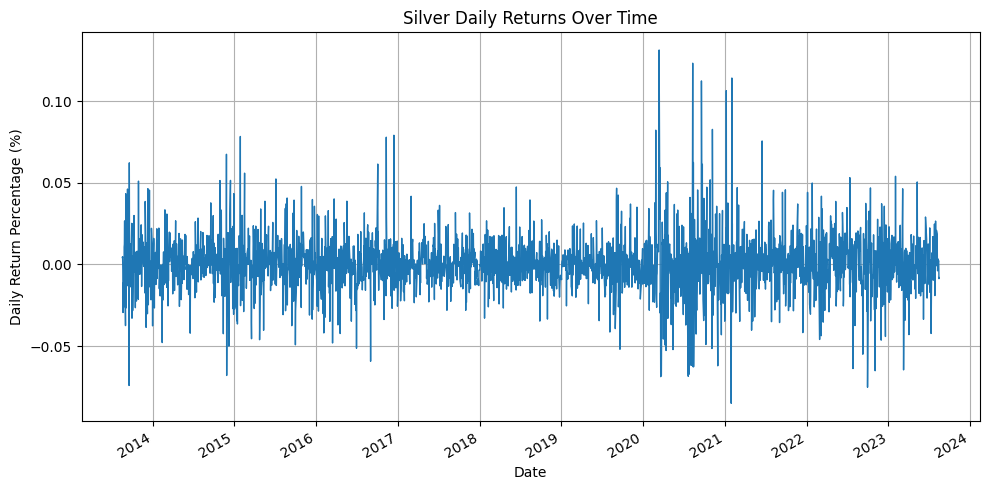

In [12]:
#Start plotting
plt.figure(figsize=(10, 5))

#Create line plot
plt.plot(silver['Date'], silver['Daily Return'], linewidth=1)  

#Adding the title and labels
plt.title('Silver Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return Percentage (%)')

plt.gcf().autofmt_xdate()
plt.grid(True)
plt.tight_layout()

plt.show()

In [13]:
def calculate_annualized_volatility(daily_returns):
    # calculate the daily standard deviation of returns
    daily_std = np.std(daily_returns)

    # convert daily standard deviation to annualized volatility
    # 252 trading days in a year
    annualized_volatility = daily_std * np.sqrt(252)

    return annualized_volatility

ann_vol = calculate_annualized_volatility(silver['Daily Return']) 
ann_vol

0.2839404730589764

In [14]:
# S&P500
market = yf.download('^GSPC', start = "2013-08-19", end = "2023-08-17")


[*********************100%%**********************]  1 of 1 completed


In [15]:
market.reset_index()
market['Daily Return'] = market['Close'].pct_change().dropna()

In [16]:
# Compare return against S&P500 and bond yield data
bond_data = yf.download('IEF', start = "2013-08-19", end = "2023-08-17")

bond_data.reset_index()
bond_data['Daily Return'] = bond_data['Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


Mean Annual Returns:
 Silver      0.033783
Gold       -0.023813
Treasury    0.160375
S&P 500     0.114119
Bonds      -0.003951
dtype: float64
Annual Volatility:
 Silver      0.282297
Gold        0.150158
Treasury    0.498091
S&P 500     0.176980
Bonds       0.064723
dtype: float64
Sharpe Ratios:
 Silver      0.119672
Gold       -0.158587
Treasury    0.321980
S&P 500     0.644815
Bonds      -0.061040
dtype: float64


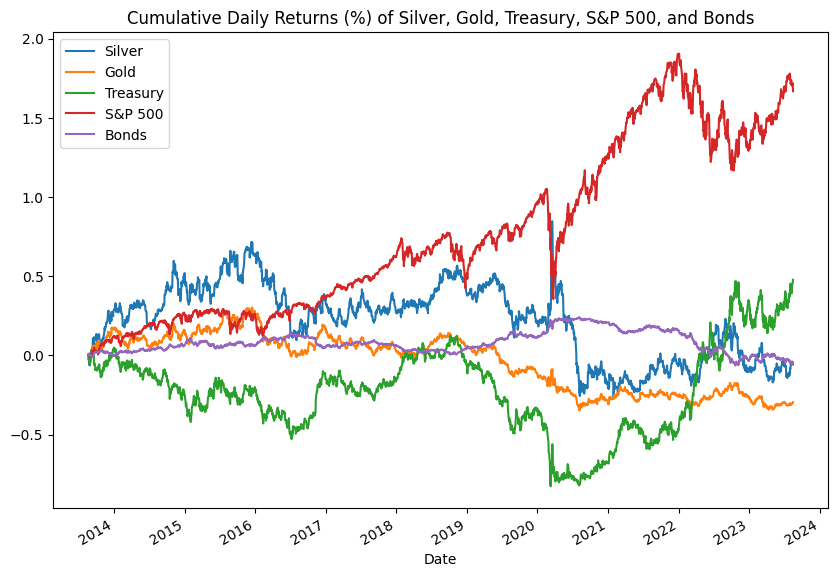

In [17]:
# Combine our Daily Returns into a single DataFrame
treasury_returns = treasury.set_index('Date')
gold_combined_returns = gold.set_index('Date')
silver_combined_returns = silver.set_index('Date') # Important to standardize everything coming up...

combined_returns = pd.DataFrame({
    'Silver': silver_combined_returns['Daily Return'].dropna(),
    'Gold': gold_combined_returns['Daily Return'].dropna(),
    'Treasury': treasury_returns['Daily Return'],
    'S&P 500': market['Daily Return'].dropna(),
    'Bonds': bond_data['Daily Return'].dropna()
}).dropna()

# Calculate mean and volatility
mean_returns = combined_returns.mean() * 252  # Annualize the mean returns
volatility = combined_returns.std() * np.sqrt(252)  # Annualize the volatility

# Risk-adjusted return (Sharpe Ratio) - assuming risk-free rate is 0 for simplicity
sharpe_ratios = mean_returns / volatility

# Plot cumulative returns
cumulative_returns = (1 + combined_returns).cumprod() - 1
cumulative_returns.plot(figsize=(10, 7))

# Display results
print("Mean Annual Returns:\n", mean_returns)
print("Annual Volatility:\n", volatility)
print("Sharpe Ratios:\n", sharpe_ratios)
plt.title('Cumulative Daily Returns (%) of Silver, Gold, Treasury, S&P 500, and Bonds')
plt.show()

In [18]:
# Economic Influence Analysis
# We compare the trends of gold to inflation, interest rate, GDP, and exchange rate data

inflation_data = pdr.get_data_fred('CPIAUCSL', start = "2013-08-19", end = "2023-08-17")
interest_rate_data = pdr.get_data_fred('DGS10', start = "2013-08-19", end = "2023-08-17")
gdp_data = pdr.get_data_fred('GDP', start = "2013-08-19", end = "2023-08-17")

# Exchange rate Data
c = CurrencyRates()
dates = pd.date_range(start = "2013-08-19", end = "2023-08-17", freq='M')
usd_to_eur_rates = [c.get_rate('USD', 'EUR', date) for date in dates]
exchange_rate_data = pd.DataFrame({'Date': dates, 'USD_to_EUR': usd_to_eur_rates})

exchange_rate_data_date = exchange_rate_data.set_index('Date')
exchange_rate_data_date.rename_axis('DATE', inplace=True)

In [19]:
# Correlation Matrix Calculation

exchange_rate_data['Date'] = pd.to_datetime(exchange_rate_data['Date'])
exchange_rate_data.set_index('Date', inplace=True)

inflation_data = inflation_data.reset_index()
inflation_data['Date'] = pd.to_datetime(inflation_data['DATE'])
inflation_data.set_index('Date', inplace=True)

gdp_data = gdp_data.reset_index()
gdp_data['Date'] = pd.to_datetime(gdp_data['DATE'])
gdp_data.set_index('Date', inplace=True)

# Resample to daily frequency and interpolate
daily_exchange_data = exchange_rate_data.resample('D').interpolate('linear')
daily_inflation_data = inflation_data.resample('D').interpolate('linear')
daily_gdp_data = gdp_data.resample('D').interpolate('linear')

combined_returns_2 = pd.DataFrame({
    'Silver Returns': silver_combined_returns['Daily Return'],
    'Gold Returns': gold_combined_returns['Daily Return'],
    'Inflation Rate': daily_inflation_data['CPIAUCSL'],  
    'Interest Rate': interest_rate_data['DGS10'],  
    'Exchange Rate': daily_exchange_data['USD_to_EUR'],
    'GDP': daily_gdp_data['GDP']
})

# Drop NaN values and calculate the correlation matrix
combined_data = combined_returns_2.dropna()

correlation_matrix = combined_data.corr()
print(correlation_matrix)

                Silver Returns  Gold Returns  Inflation Rate  Interest Rate  \
Silver Returns        1.000000      0.777769        0.000304       0.022818   
Gold Returns          0.777769      1.000000       -0.003151       0.009218   
Inflation Rate        0.000304     -0.003151        1.000000       0.270170   
Interest Rate         0.022818      0.009218        0.270170       1.000000   
Exchange Rate        -0.010146     -0.011656        0.481733       0.115132   
GDP                  -0.002802     -0.003889        0.987078       0.205815   

                Exchange Rate       GDP  
Silver Returns      -0.010146 -0.002802  
Gold Returns        -0.011656 -0.003889  
Inflation Rate       0.481733  0.987078  
Interest Rate        0.115132  0.205815  
Exchange Rate        1.000000  0.493260  
GDP                  0.493260  1.000000  


In [20]:
# Creating a Regression Model

# Standardize indexing to date
treasury_date = treasury.set_index('Date') 
silver_date = silver.set_index('Date')
gold_date = gold.set_index('Date')


combined_close = pd.DataFrame({
    'Silver': silver_date['Close/Last'],
    'Gold': gold_date['Close/Last'],
    'Treasury': treasury_date['Close'],  
    'S&P 500': market['Close'],  
    'Bonds': bond_data['Close']
})

# Fill in missing values via Interpolation
combined_close_interp = combined_close.interpolate('linear')

X_silver = combined_close_interp[['Treasury', 'S&P 500', 'Bonds', 'Gold']]  # Independent variables
y_silver = combined_close_interp['Silver']  # Dependent variable

X_gold = combined_close_interp[['Treasury', 'S&P 500', 'Bonds', 'Silver']]
y_gold = combined_close_interp['Gold']

# Create an OLS model and fit it
silver_model = sm.OLS(y_silver, X_silver).fit()

print(silver_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Silver   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          5.250e+04
Date:                Thu, 30 Nov 2023   Prob (F-statistic):                        0.00
Time:                        22:24:17   Log-Likelihood:                         -5521.5
No. Observations:                2539   AIC:                                  1.105e+04
Df Residuals:                    2535   BIC:                                  1.107e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<Axes: xlabel='Date'>

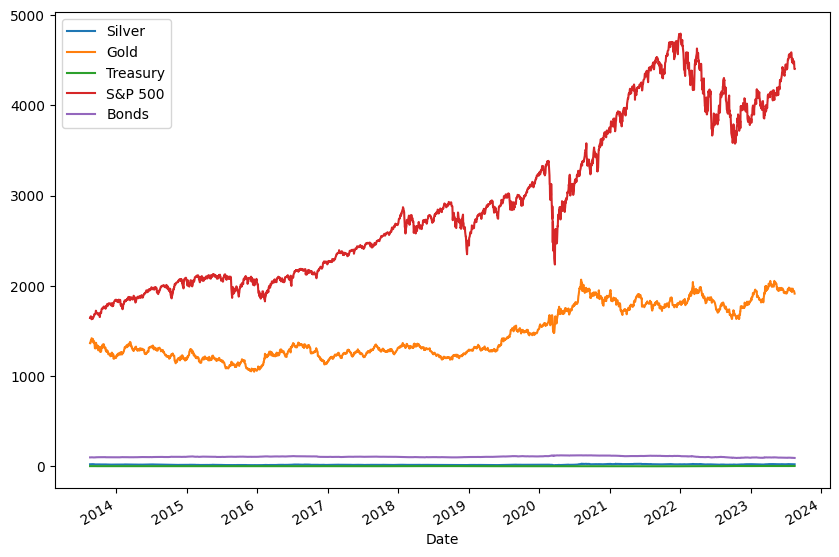

In [21]:
combined_close_interp.plot(figsize=(10, 7))

In [22]:
combined_close_interp.head(10)

,Silver,Gold,Treasury,S&P 500,Bonds
Date,,,,,
2013-08-19,23.215,1365.7,2.884,1646.060059,99.709999
2013-08-20,23.118,1372.6,2.814,1652.349976,100.250000
2013-08-21,23.009,1370.1,2.855,1642.800049,99.620003
2013-08-22,23.080,1370.8,2.901,1656.959961,99.580002
2013-08-23,23.781,1395.8,2.818,1663.500000,100.139999
2013-08-26,24.055,1393.1,2.805,1656.780029,100.339996
2013-08-27,24.700,1420.2,2.721,1630.479980,100.910004
2013-08-28,24.439,1418.8,2.782,1634.959961,100.500000
2013-08-29,24.140,1412.9,2.751,1638.170044,100.599998


In [23]:
split_point = int(len(combined_close_interp) * 0.7)

# Split the data into training and testing sets
X_silver_train = X_silver[:split_point]
y_silver_train = y_silver[:split_point]
X_silver_test = X_silver[split_point:]
y_silver_test = y_silver[split_point:]

# Add a constant to the training set for the intercept
X_silver_train = sm.add_constant(X_silver_train)

# Fit the OLS model on the training data
silver_model = sm.OLS(y_silver_train, X_silver_train).fit()

# Add a constant to the testing set for the intercept
X_silver_test = sm.add_constant(X_silver_test)

# Make predictions on the testing set
y_silver_pred = silver_model.predict(X_silver_test)

# Calculate the root mean squared error (RMSE) for the predictions
silver_test_rmse = rmse(y_silver_test, y_silver_pred)
print(f'Test RMSE: {silver_test_rmse}')


Test RMSE: 4.679267326684104


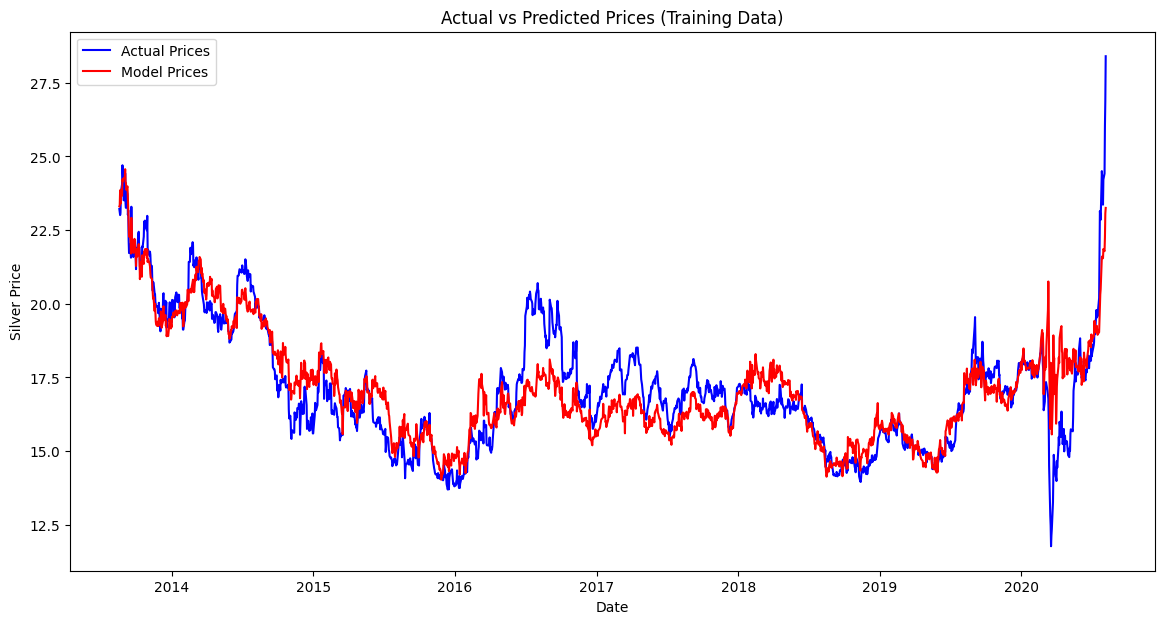

Training RMSE: 1.0280494926601118


In [24]:
y_silver_train_pred = silver_model.predict(sm.add_constant(X_silver_train))

# Calculate the RMSE for the training predictions
silver_train_rmse = rmse(y_silver_train, y_silver_train_pred)

# Plotting the actual vs model prices for the training set
plt.figure(figsize=(14, 7))
plt.plot(y_silver_train.index, y_silver_train, label='Actual Prices', color='blue')
plt.plot(y_silver_train.index, y_silver_train_pred, label='Model Prices', color='red')

# Adding titles and labels
plt.title(f'Actual vs Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Silver Price')
plt.legend()
plt.show()
print(f'Training RMSE: {silver_train_rmse}')

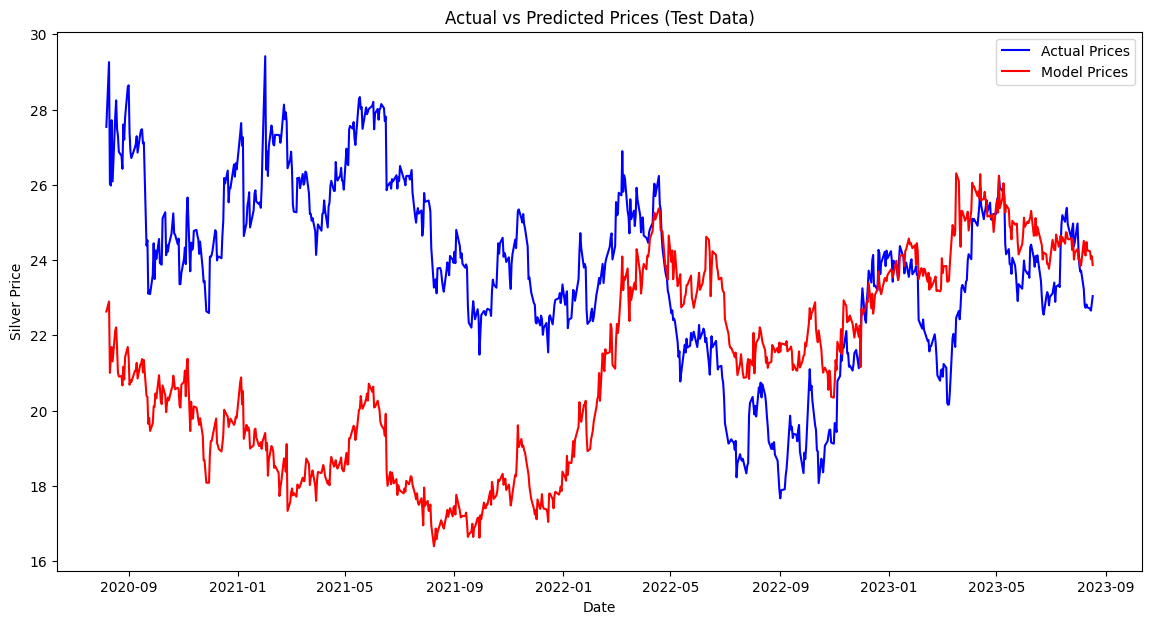

Test RMSE: 4.679267326684104


In [25]:
# Plotting the actual vs predicted prices

plt.figure(figsize=(14, 7))
plt.plot(y_silver_test.index, y_silver_test, label='Actual Prices', color='blue')
plt.plot(y_silver_test.index, y_silver_pred, label='Model Prices', color='red')

# Adding titles and labels
plt.title(f'Actual vs Predicted Prices (Test Data)')
plt.xlabel('Date')
plt.ylabel('Silver Price')
plt.legend()
plt.show()
print(f'Test RMSE: {silver_test_rmse}')

In [26]:
# Split the data into training and testing sets
X_gold_train = X_gold[:split_point]
y_gold_train = y_gold[:split_point]
X_gold_test = X_gold[split_point:]
y_gold_test = y_gold[split_point:]

# Add a constant to the training set for the intercept
X_gold_train = sm.add_constant(X_gold_train)

# Fit the OLS model on the training data
gold_model = sm.OLS(y_gold_train, X_gold_train).fit()

# Add a constant to the testing set for the intercept
X_gold_test = sm.add_constant(X_gold_test)

# Make predictions on the testing set
y_gold_pred = gold_model.predict(X_gold_test)

# Calculate the root mean squared error (RMSE) for the predictions
gold_test_rmse = rmse(y_gold_test, y_gold_pred)
print(f'Test RMSE: {gold_test_rmse}')

Test RMSE: 202.43065531100362


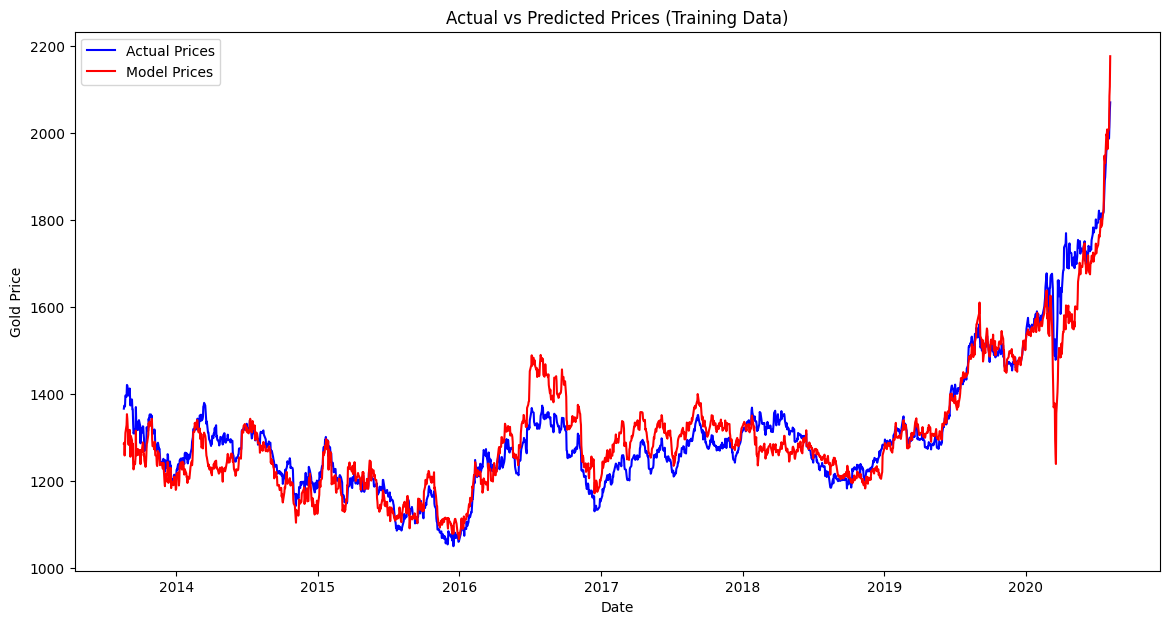

Training RMSE: 49.026973496455106


In [27]:
y_gold_train_pred = gold_model.predict(sm.add_constant(X_gold_train))

# Calculate the RMSE for the training predictions
gold_train_rmse = rmse(y_gold_train, y_gold_train_pred)

# Plotting the actual vs model prices for the training set
plt.figure(figsize=(14, 7))
plt.plot(y_gold_train.index, y_gold_train, label='Actual Prices', color='blue')
plt.plot(y_gold_train.index, y_gold_train_pred, label='Model Prices', color='red')

# Adding titles and labels
plt.title(f'Actual vs Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()
print(f'Training RMSE: {gold_train_rmse}')

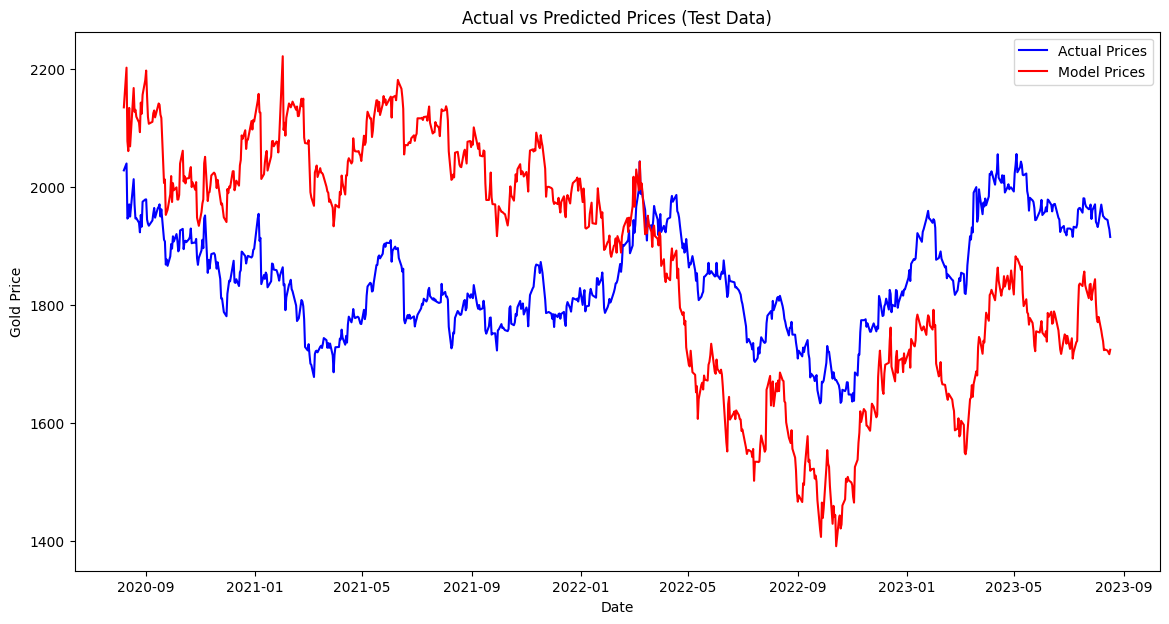

Test RMSE: 202.43065531100362


In [28]:
# Plotting the actual vs predicted prices

plt.figure(figsize=(14, 7))
plt.plot(y_gold_test.index, y_gold_test, label='Actual Prices', color='blue')
plt.plot(y_gold_test.index, y_gold_pred, label='Model Prices', color='red')

# Adding titles and labels
plt.title(f'Actual vs Predicted Prices (Test Data)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()
print(f'Test RMSE: {gold_test_rmse}')